# Preliminary Step

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import ccf
from scipy.stats import skew, kurtosis, shapiro, spearmanr, pearsonr

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

df_main = pd.read_csv('credit_data.csv')
df_benchmark = pd.read_csv('benchmark_data.csv')
df_main['Date'] = pd.to_datetime(df_main['Date'], dayfirst=True)
df_main.set_index('Date', inplace=True)

df_main.info()
df_main.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2018-01-01 to 2024-12-31
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   VIX                 1827 non-null   float64
 1   T-Bill_13W_Yield    1827 non-null   float64
 2   10Y_Treasury_Yield  1827 non-null   float64
 3   Credit_Spread       1827 non-null   float64
dtypes: float64(4)
memory usage: 71.4 KB


,VIX,T-Bill_13W_Yield,10Y_Treasury_Yield,Credit_Spread
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,20.025819,0.999144,2.501993,1.502848
std,5.094063,0.198425,0.288734,0.348720
min,3.685516,0.289908,1.543891,0.242011
25%,16.687064,0.862321,2.309714,1.279083
50%,20.095059,0.999196,2.506396,1.501573
75%,23.555050,1.136868,2.699709,1.743830
max,35.069549,1.728127,3.444251,2.637945


# Time Series Visualization

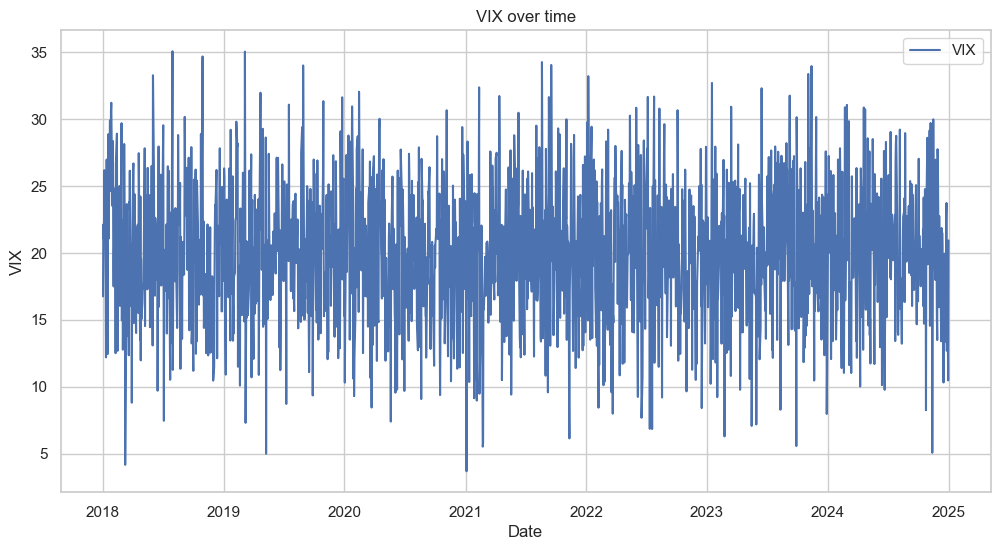

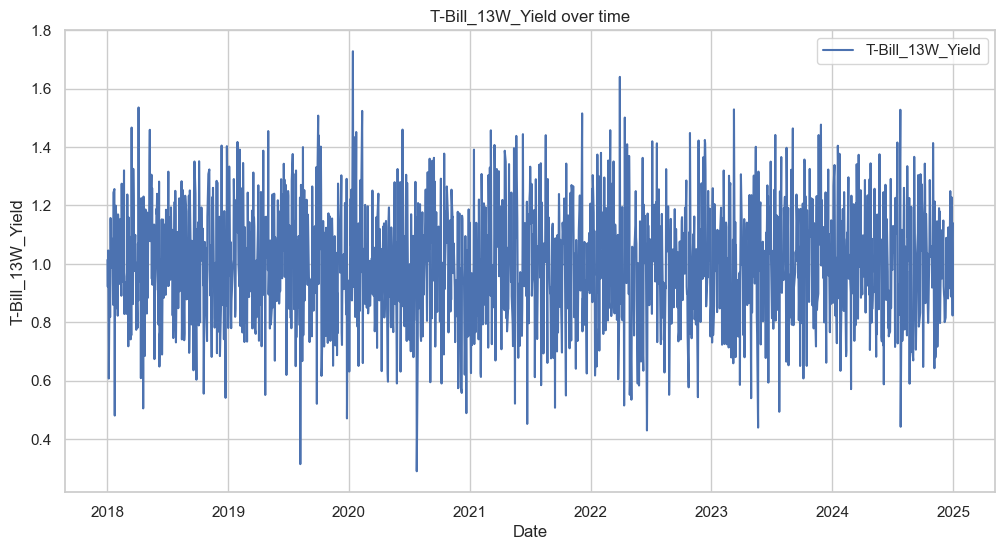

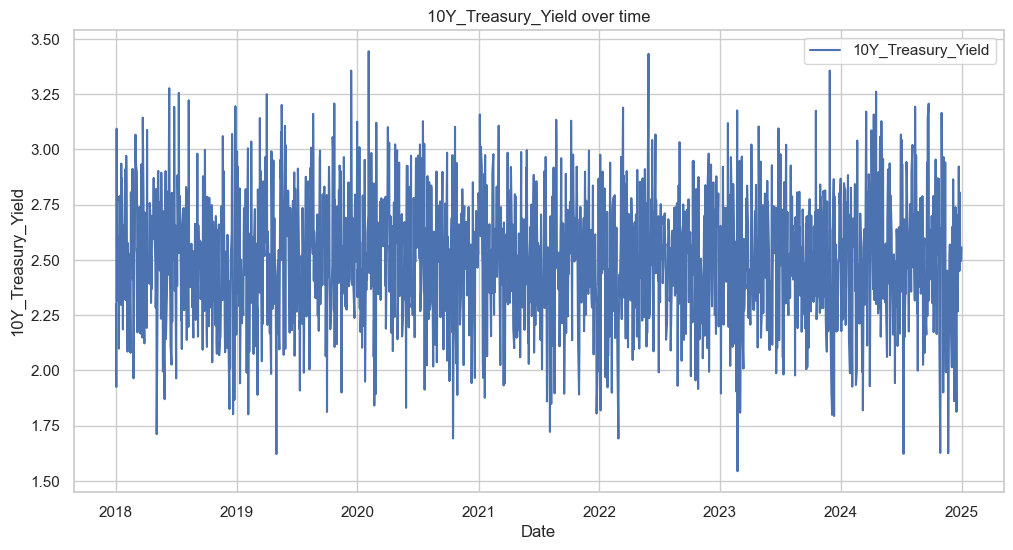

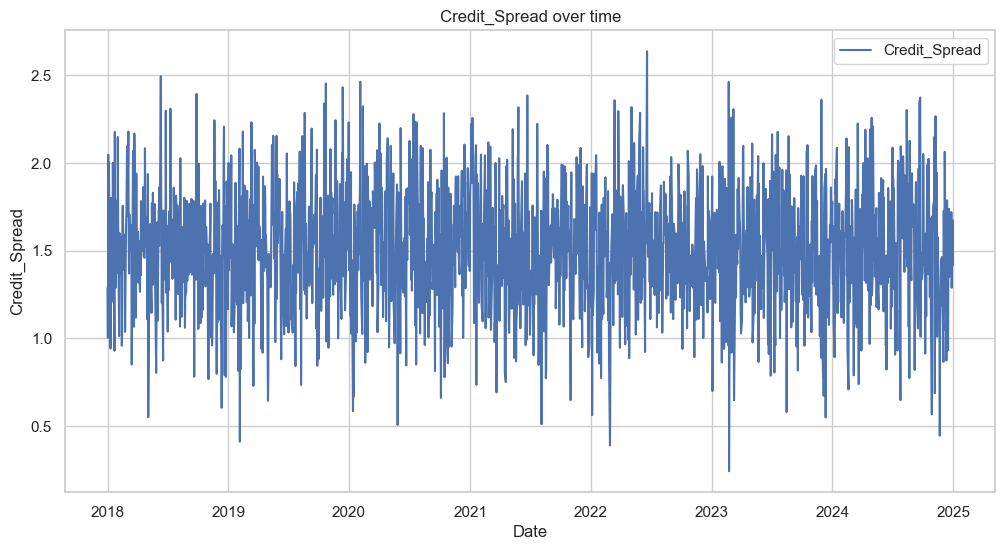

In [190]:
for col in df_main.columns:
    plt.figure()
    plt.plot(df_main.index, df_main[col], label=col)
    plt.title(f'{col} over time')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.show()

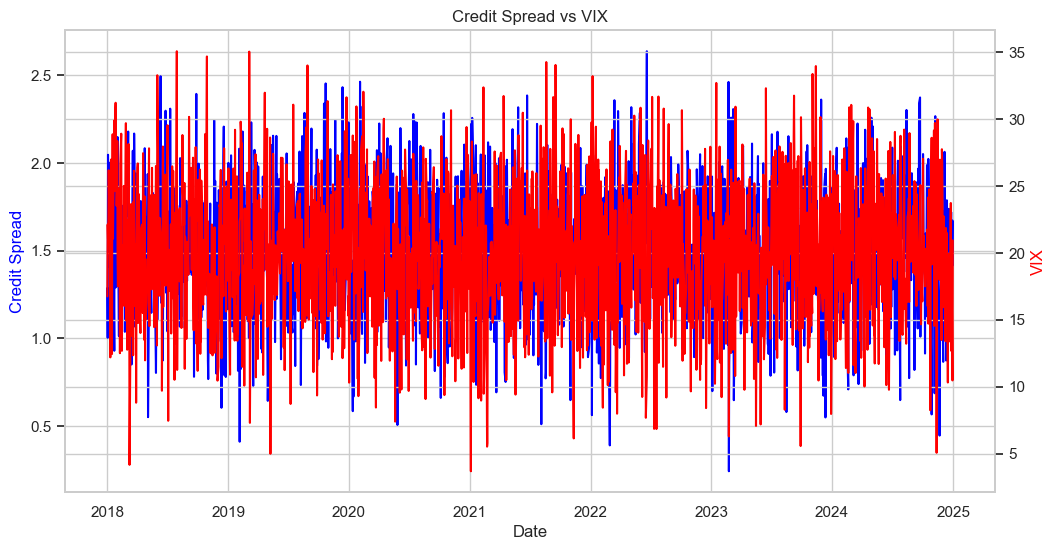

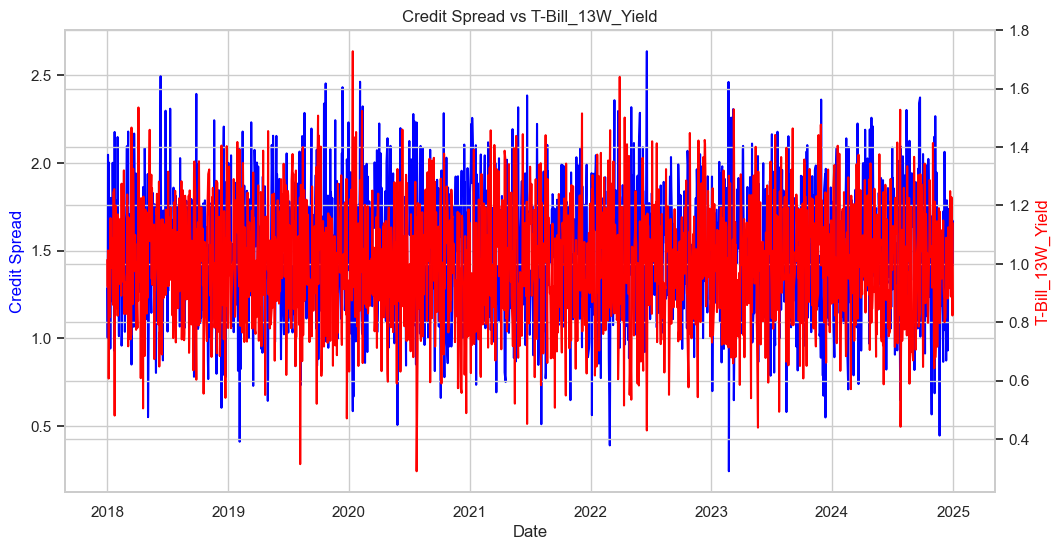

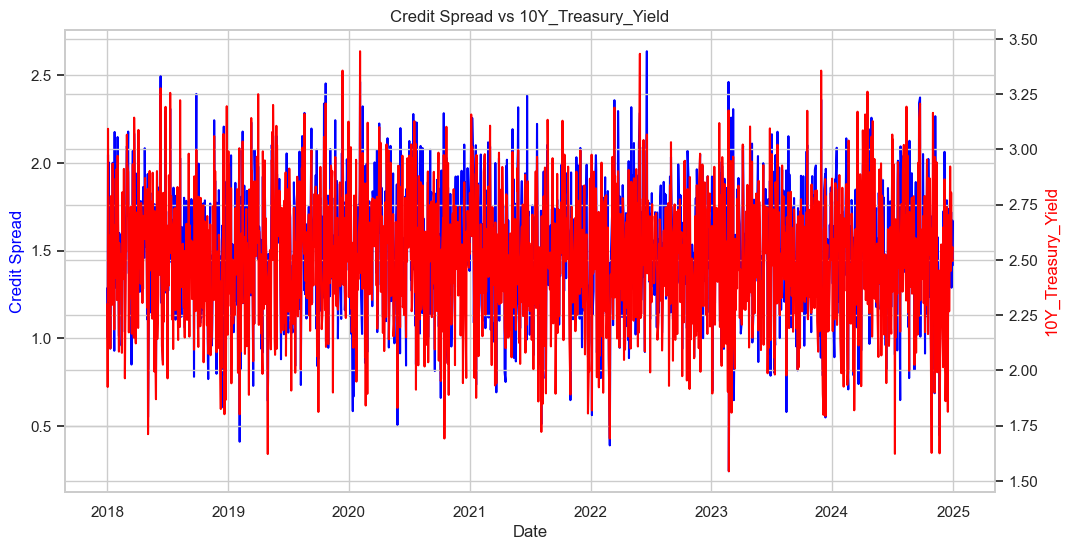

In [191]:
for col in ['VIX', 'T-Bill_13W_Yield', '10Y_Treasury_Yield']:
    fig, ax1 = plt.subplots()
    
    ax1.plot(df_main.index, df_main['Credit_Spread'], color='blue', label='Credit Spread')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Credit Spread', color='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(df_main.index, df_main[col], color='red', label=col)
    ax2.set_ylabel(col, color='red')
    
    plt.title(f'Credit Spread vs {col}')
    plt.show()

# Correlation Analysis

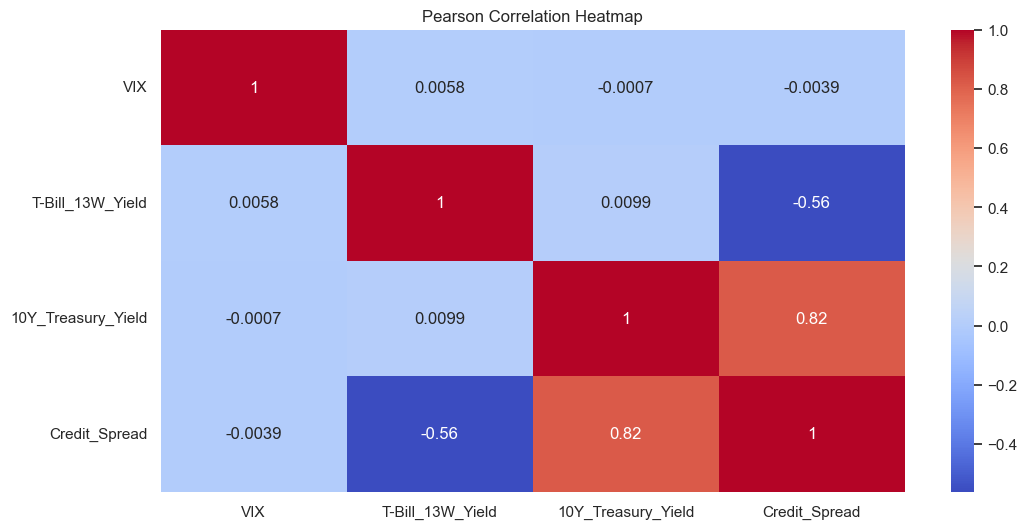

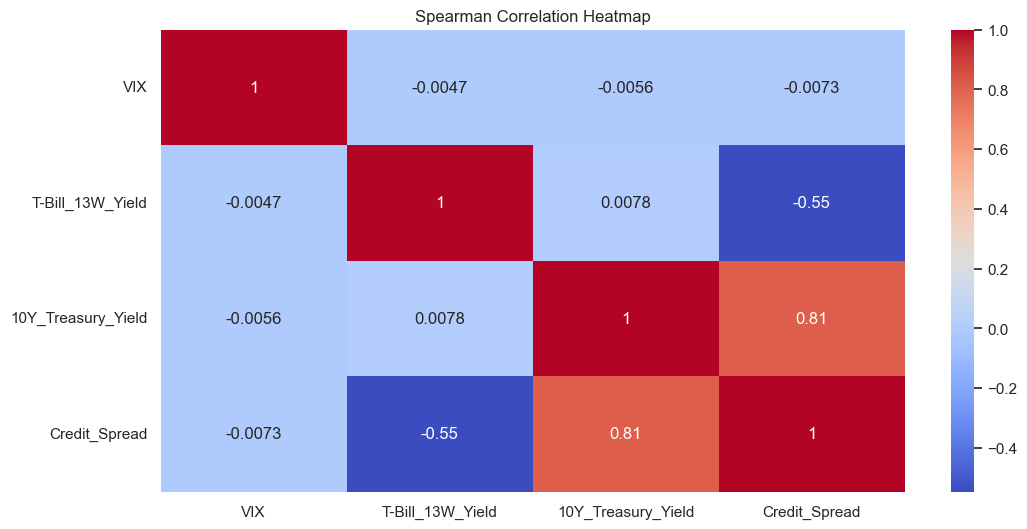

In [192]:
pearson_corr = df_main.corr(method='pearson')
spearman_corr = df_main.corr(method='spearman')

sns.heatmap(pearson_corr, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Heatmap')
plt.show()

sns.heatmap(spearman_corr, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Heatmap')
plt.show()

# Distribution Analysis

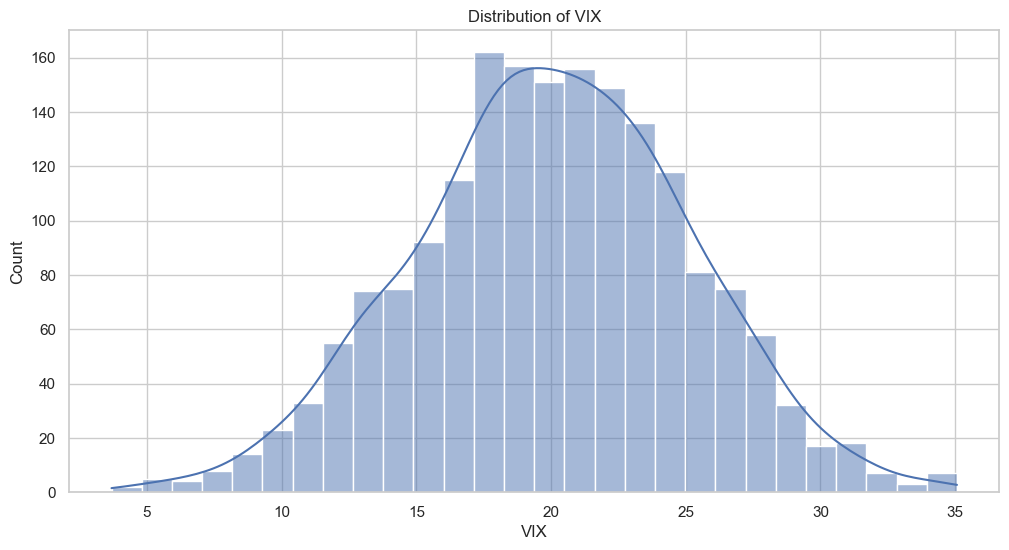

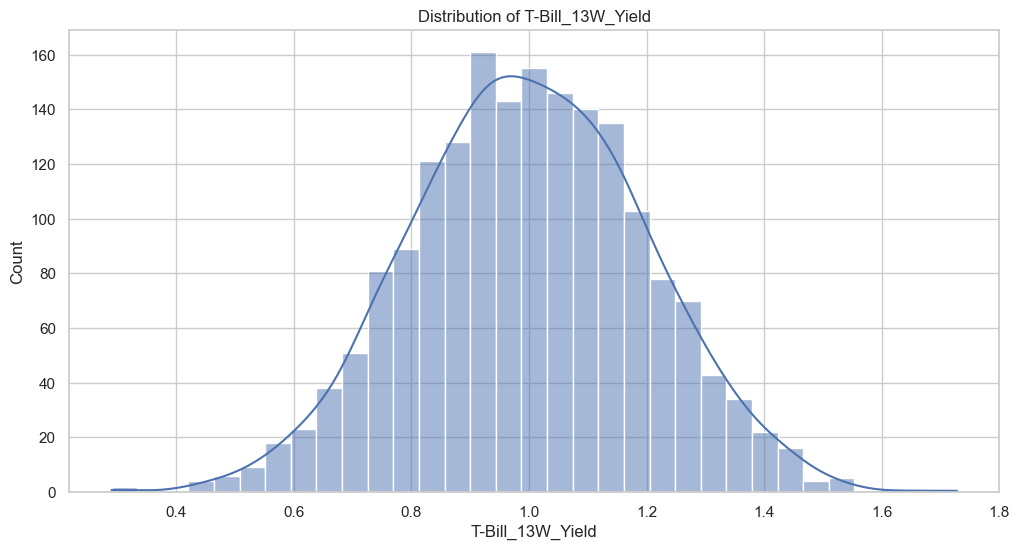

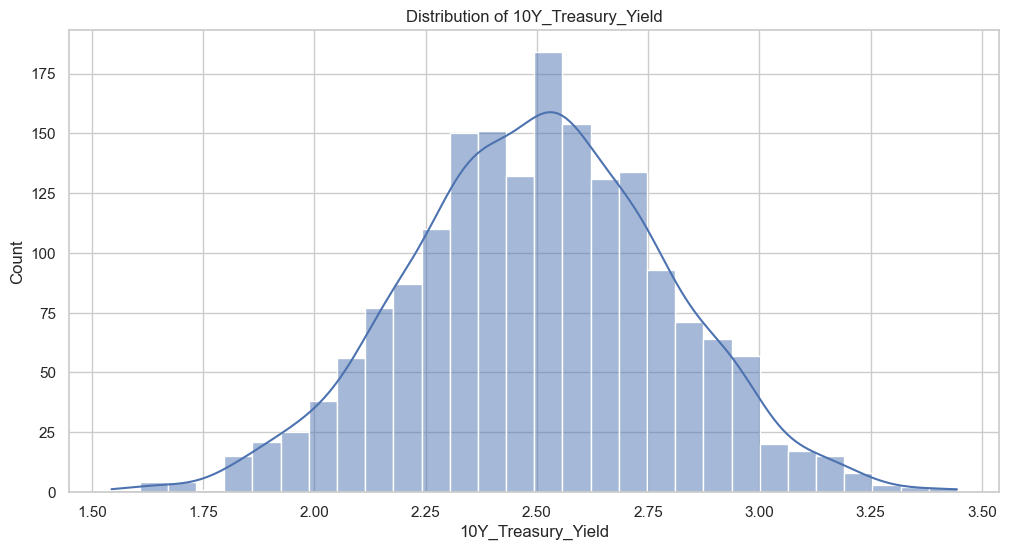

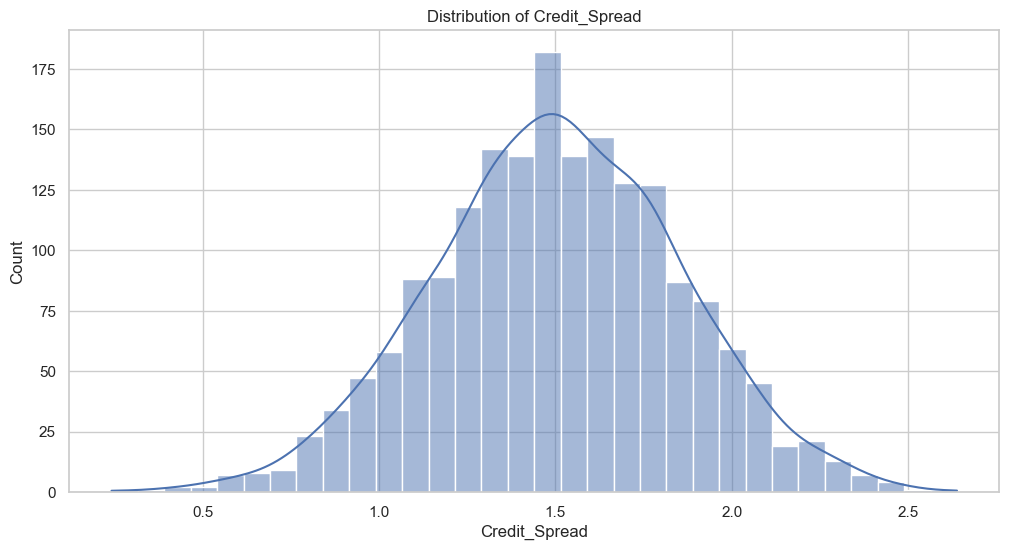

In [193]:
for col in df_main.columns:
    sns.histplot(df_main[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


In [194]:
for col in df_main.select_dtypes(include='number').columns:
    print(f'{col}: Skewness = {skew(df_main[col]):.2f}, Kurtosis = {kurtosis(df_main[col]):.2f}')

VIX: Skewness = -0.07, Kurtosis = -0.08
T-Bill_13W_Yield: Skewness = -0.00, Kurtosis = -0.07
10Y_Treasury_Yield: Skewness = -0.03, Kurtosis = -0.02
Credit_Spread: Skewness = -0.06, Kurtosis = -0.01


In [195]:
for col in df_main.select_dtypes(include='number').columns:
    stat, p = shapiro(df_main[col].sample(500))
    print(f'{col}: Shapiro-Wilk Test p-value = {p:.4f}')

VIX: Shapiro-Wilk Test p-value = 0.8602
T-Bill_13W_Yield: Shapiro-Wilk Test p-value = 0.6796
10Y_Treasury_Yield: Shapiro-Wilk Test p-value = 0.6885
Credit_Spread: Shapiro-Wilk Test p-value = 0.9434


# Lag Relationship Testing (Cross Correlation)

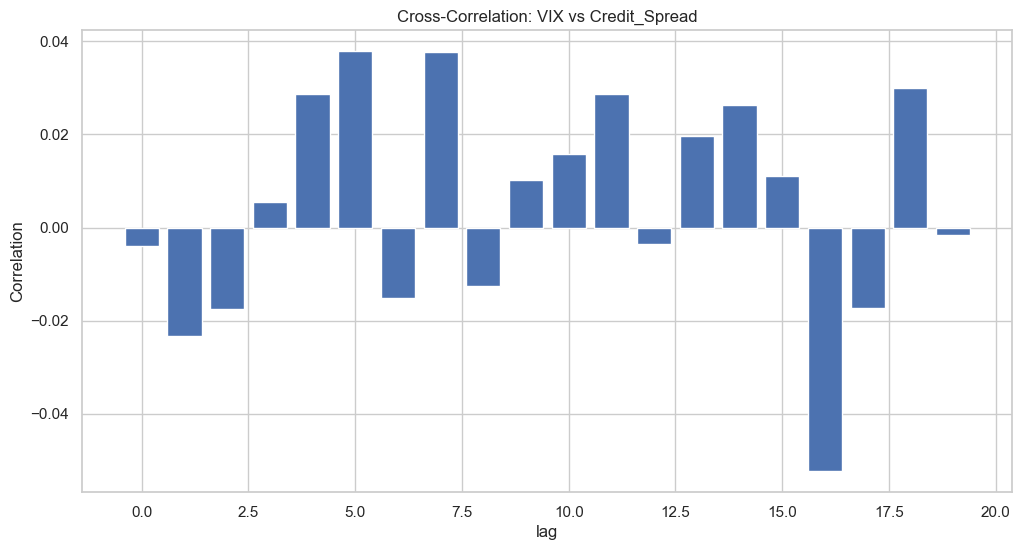

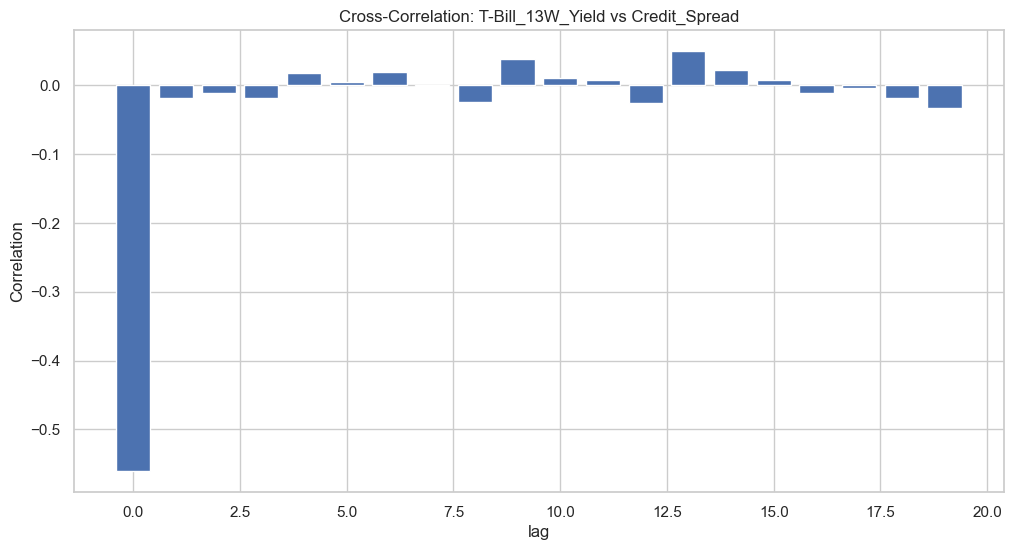

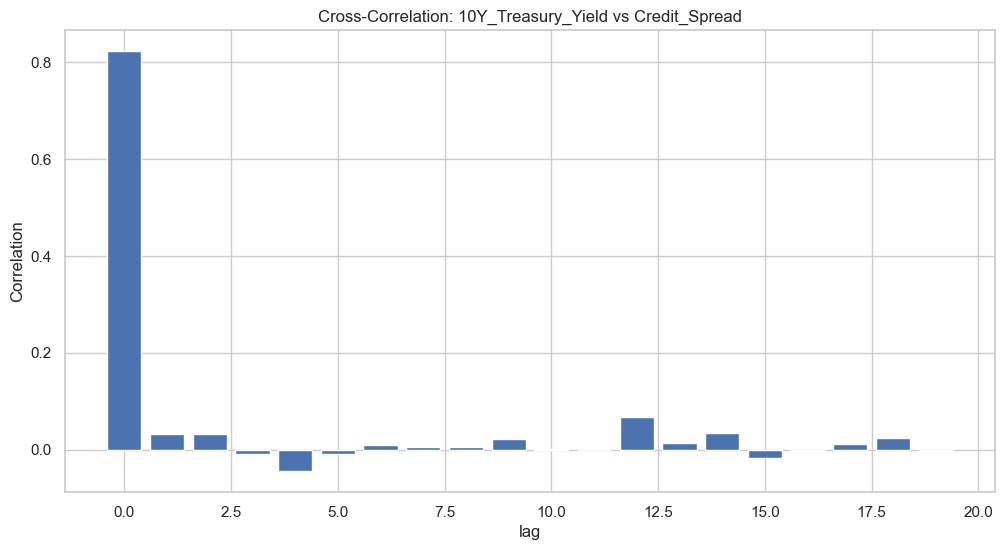

In [196]:
def plot_cross_corr(x, y, lags=20):
    result = ccf(x, y)[:lags]
    plt.bar(range(lags), result)
    plt.title(f'Cross-Correlation: {x.name} vs {y.name}')
    plt.xlabel('lag')
    plt.ylabel('Correlation')
    plt.show()

for col in ['VIX', 'T-Bill_13W_Yield', '10Y_Treasury_Yield']:
    plot_cross_corr(df_main[col], df_main['Credit_Spread'])

# VIX Regime Segmentation

In [197]:
vix_median = df_main['VIX'].median()

In [198]:
df_main['Regime'] = np.where(df_main['VIX'] >= vix_median, 'High Vol', 'Low Vol')

In [199]:
df_main.groupby('Regime').describe()

VIX                                                        \
          count       mean       std        min        25%        50%   
Regime                                                                  
High Vol  914.0  24.093276  2.979937  20.095059  21.786603  23.555050   
Low Vol   913.0  15.953908  3.144358   3.685516  13.921357  16.684617   

                               T-Bill_13W_Yield            ...  \
                75%        max            count      mean  ...   
Regime                                                     ...   
High Vol  25.916940  35.069549            914.0  0.994412  ...   
Low Vol   18.453181  20.072549            913.0  1.003882  ...   

         10Y_Treasury_Yield           Credit_Spread                      \
                        75%       max         count      mean       std   
Regime                                                                    
High Vol           2.689890  3.444251         914.0  1.501145  0.343349   
Low Vol            2.706207  3.432691         913.0  1.504553  0.354196   

                                                            
               min       25%       50%       75%       max  
Regime                                                      
High Vol  0.410468  1.276159  1.495424  1.732756  2.495271  
Low Vol   0.242011  1.279880  1.509675  1.747509  2.637945  

[2 rows x 32 columns]

In [200]:
for regime in ['High Vol', 'Low Vol']:
    print(f"\n{regime} Regime Correlatin Matrix:")
    corr_matrix = df_main[df_main['Regime'] == regime].select_dtypes(include='number').corr()
    print(corr_matrix)
    


High Vol Regime Correlatin Matrix:
                         VIX  T-Bill_13W_Yield  10Y_Treasury_Yield  \
VIX                 1.000000          0.038313            0.009285   
T-Bill_13W_Yield    0.038313          1.000000            0.045122   
10Y_Treasury_Yield  0.009285          0.045122            1.000000   
Credit_Spread      -0.015083         -0.557556            0.804136   

                    Credit_Spread  
VIX                     -0.015083  
T-Bill_13W_Yield        -0.557556  
10Y_Treasury_Yield       0.804136  
Credit_Spread            1.000000  

Low Vol Regime Correlatin Matrix:
                         VIX  T-Bill_13W_Yield  10Y_Treasury_Yield  \
VIX                 1.000000          0.044684            0.046301   
T-Bill_13W_Yield    0.044684          1.000000           -0.027744   
10Y_Treasury_Yield  0.046301         -0.027744            1.000000   
Credit_Spread       0.013921         -0.565941            0.839830   

                    Credit_Spread  
VIX        

In [201]:
df_main.describe()

,VIX,T-Bill_13W_Yield,10Y_Treasury_Yield,Credit_Spread
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,20.025819,0.999144,2.501993,1.502848
std,5.094063,0.198425,0.288734,0.348720
min,3.685516,0.289908,1.543891,0.242011
25%,16.687064,0.862321,2.309714,1.279083
50%,20.095059,0.999196,2.506396,1.501573
75%,23.555050,1.136868,2.699709,1.743830
max,35.069549,1.728127,3.444251,2.637945


# Phase 3: Feature Engineering

In [202]:
import pandas as pd

 Lag Features (1-Day, 5-Day, 10-Day)

In [203]:
lag_days = [1, 5, 10]
variables = ['VIX', 'T-Bill_13W_Yield', '10Y_Treasury_Yield', 'Credit_Spread']

for var in variables:
    for lag in lag_days:
        df_main[f'{var}_lag_{lag}'] = df_main[var].shift(lag)

Moving Averages (5-day, 10-day)

In [204]:
ma_windows = [5, 10]

for var in variables:
    for window in ma_windows:
        df_main[f'{var}_MA_{window}'] = df_main[var].rolling(window).mean()

Rolling Volatility (5-day, 10-day)

In [205]:
for window in ma_windows:
    df_main[f'VIX_vol_{window}'] = df_main['VIX'].rolling(window).std()

Yield Curve Differential (10Y - 13W)

In [206]:
df_main['Yield_Curve_Steepness'] = df_main['10Y_Treasury_Yield'] - df_main['T-Bill_13W_Yield']

Daily % Change in VIX

In [207]:
df_main['VIX_pct_change'] = df_main['VIX'].pct_change()*100

Daily % Change in Credit Spread

In [208]:
df_main['Credit_Spread_pct_change'] = df_main['Credit_Spread'].pct_change()*100

Relative Change to Moving Averages

In [209]:
for var in variables:
    for window in ma_windows:
        df_main[f'{var}_to_MA_{window}_diff'] = (df_main[var] - df_main[f'{var}_MA_{window}']) / df_main[f'{var}_MA_{window}']

Volatility Ratio (VIX vol 5-day to 10-day)

In [210]:
df_main['VIX_vol_ratio'] = df_main['VIX_vol_5'] / df_main['VIX_vol_10']

Momentum Features for Credit Spread (3-day and 7-day)

In [211]:
for lag in [3, 7]:
    df_main[f'Credit_Spread_momentum_{lag}'] = df_main['Credit_Spread'] - df_main['Credit_Spread'].shift(lag)

Z-Score of VIX based on 5-day moving average and 5-day rolling volatility

In [212]:
df_main['VIX_zscore'] = (df_main['VIX']- df_main['VIX_MA_5']) / df_main['VIX_vol_5']

Interaction Features

In [213]:
df_main['VIX_x_Yield_Steepness'] = df_main['VIX'] * df_main['Yield_Curve_Steepness']
df_main['VIX_pct_x_Yield_Steepness'] = df_main['VIX_pct_change'] * df_main['Yield_Curve_Steepness']

VIX volatility (rolling std dev)


In [214]:
df_main['VIX_std_5'] = df_main['VIX'].rolling(window=5).std()


Credit Spread z-score (10-period rolling)


In [215]:
df_main['Credit_Spread_zscore_10'] = (
    (df_main['Credit_Spread'] - df_main['Credit_Spread'].rolling(10).mean()) 
    / df_main['Credit_Spread'].rolling(10).std()
)


VIX 5-day momentum


In [216]:
df_main['VIX_momentum_5'] = df_main['VIX'] - df_main['VIX'].shift(5)


10Y Yield 5-day EMA (Exponential Moving Average)


In [217]:
df_main['10Y_Treasury_Yield_ema_5'] = df_main['10Y_Treasury_Yield'].ewm(span=5, adjust=False).mean()


Credit Spread volatility of volatility (rolling std dev of rolling std dev)


In [218]:
df_main['Credit_Spread_volatility_5'] = df_main['Credit_Spread'].rolling(5).std()
df_main['Credit_Spread_vol_of_vol_5'] = df_main['Credit_Spread_volatility_5'].rolling(5).std()


High VIX flag (1 if VIX above 90th percentile of rolling 60-day window)


In [219]:
df_main['High_VIX_flag'] = (df_main['VIX'] > df_main['VIX'].rolling(60).quantile(0.9)).astype(int)


Credit Spread 5-day return


In [220]:
df_main['Credit_Spread_return_5'] = df_main['Credit_Spread'] - df_main['Credit_Spread'].shift(5)


Credit Spread 10-day rolling volatility


In [221]:
df_main['Credit_Spread_volatility_10'] = df_main['Credit_Spread'].rolling(10).std()

Momentum Change (Acceleration/Deceleration)

In [222]:
df_main['Credit_Spread_momentum_delta'] = df_main['Credit_Spread_momentum_3'] - df_main['Credit_Spread_momentum_7']


EMA-MA Spread Signal (short-term vs long-term spread strength)

In [223]:
df_main['10Y_Yield_ema5_vs_ma10'] = df_main['10Y_Treasury_Yield_ema_5'] - df_main['10Y_Treasury_Yield_MA_10']


Rolling Z-Score of Momentum

In [224]:
df_main['Credit_Spread_momentum_3_z'] = (
    df_main['Credit_Spread_momentum_3'] - df_main['Credit_Spread_momentum_3'].rolling(10).mean()
) / df_main['Credit_Spread_momentum_3'].rolling(10).std()


Credit Spread Reversal Probability Signal

In [225]:
df_main['Spread_reversal_flag'] = ((df_main['Credit_Spread_momentum_3'] < 0) & (df_main['Credit_Spread_momentum_7'] > 0)).astype(int)


10Y Yield vs 13W T-Bill EMA spread (Steepness Slope)

In [226]:
df_main['Yield_curve_ema_steepness'] = df_main['10Y_Treasury_Yield_ema_5'] - df_main['T-Bill_13W_Yield'].ewm(span=5, adjust=False).mean()


Volatility Oscillator

In [227]:
df_main['Credit_Spread_vol_oscillator'] = df_main['Credit_Spread_volatility_5'] - df_main['Credit_Spread_volatility_10']


High Volatility Regime Flag

In [228]:
df_main['High_vol_regime'] = (df_main['Credit_Spread_volatility_10'] > df_main['Credit_Spread_volatility_10'].rolling(60).quantile(0.9)).astype(int)


Lagged VIX Z-Score

In [229]:
df_main['VIX_zscore_lag_1'] = df_main['VIX_zscore'].shift(1)


In [230]:
df_main.tail()

,VIX,T-Bill_13W_Yield,10Y_Treasury_Yield,Credit_Spread,Regime,VIX_lag_1,VIX_lag_5,VIX_lag_10,T-Bill_13W_Yield_lag_1,T-Bill_13W_Yield_lag_5,...,Credit_Spread_return_5,Credit_Spread_volatility_10,Credit_Spread_momentum_delta,10Y_Yield_ema5_vs_ma10,Credit_Spread_momentum_3_z,Spread_reversal_flag,Yield_curve_ema_steepness,Credit_Spread_vol_oscillator,High_vol_regime,VIX_zscore_lag_1
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-25,23.730057,0.888315,2.450349,1.562035,High Vol,22.547458,17.523677,18.981832,0.986776,1.037146,...,0.122003,0.275711,-0.419383,0.077768,0.069276,0,1.562645,-0.123335,0,1.320654
2024-12-26,12.689504,1.084723,2.805043,1.720319,Low Vol,23.730057,19.944816,21.511164,0.888315,0.963505,...,-0.018622,0.258892,-0.276901,0.100099,-0.394343,0,1.615203,-0.110634,0,1.054860
2024-12-27,20.521115,1.228188,2.517219,1.289031,High Vol,12.689504,16.000055,20.420118,1.084723,0.916845,...,-0.061618,0.250966,-0.227136,0.082868,-1.342221,0,1.506479,-0.077007,0,-0.964732
2024-12-30,10.472274,0.823259,2.495359,1.672101,Low Vol,20.521115,13.375835,10.317795,1.228188,1.249092,...,-0.001732,0.167392,0.176906,-0.018929,0.080954,0,1.561686,0.006342,0,0.375280
2024-12-31,20.932712,1.139627,2.556615,1.416987,High Vol,10.472274,22.547458,16.861257,0.823259,0.986776,...,-0.250180,0.165448,-0.369670,-0.024342,-0.933200,1,1.513453,0.013616,0,-1.250108


In [231]:
df_main

,VIX,T-Bill_13W_Yield,10Y_Treasury_Yield,Credit_Spread,Regime,VIX_lag_1,VIX_lag_5,VIX_lag_10,T-Bill_13W_Yield_lag_1,T-Bill_13W_Yield_lag_5,...,Credit_Spread_return_5,Credit_Spread_volatility_10,Credit_Spread_momentum_delta,10Y_Yield_ema5_vs_ma10,Credit_Spread_momentum_3_z,Spread_reversal_flag,Yield_curve_ema_steepness,Credit_Spread_vol_oscillator,High_vol_regime,VIX_zscore_lag_1
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,16.753388,1.013793,2.300598,1.286806,Low Vol,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.286806,NaN,0,NaN
2018-01-02,22.121129,0.921702,1.925130,1.003428,High Vol,16.753388,NaN,NaN,1.013793,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.192346,NaN,0,NaN
2018-01-03,21.063509,1.045979,3.093456,2.047477,High Vol,22.121129,NaN,NaN,0.921702,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.477390,NaN,0,NaN
2018-01-04,22.412022,0.887613,2.315705,1.428092,High Vol,21.063509,NaN,NaN,1.045979,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.460957,NaN,0,NaN
2018-01-05,26.179142,0.607334,2.611276,2.003943,High Vol,22.412022,NaN,NaN,0.887613,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1.641952,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,23.730057,0.888315,2.450349,1.562035,High Vol,22.547458,17.523677,18.981832,0.986776,1.037146,...,0.122003,0.275711,-0.419383,0.077768,0.069276,0,1.562645,-0.123335,0,1.320654
2024-12-26,12.689504,1.084723,2.805043,1.720319,Low Vol,23.730057,19.944816,21.511164,0.888315,0.963505,...,-0.018622,0.258892,-0.276901,0.100099,-0.394343,0,1.615203,-0.110634,0,1.054860
2024-12-27,20.521115,1.228188,2.517219,1.289031,High Vol,12.689504,16.000055,20.420118,1.084723,0.916845,...,-0.061618,0.250966,-0.227136,0.082868,-1.342221,0,1.506479,-0.077007,0,-0.964732


In [232]:
df_main.dropna(inplace=True)

In [233]:
df_main.isna().sum()

VIX                             0
T-Bill_13W_Yield                0
10Y_Treasury_Yield              0
Credit_Spread                   0
Regime                          0
                               ..
Spread_reversal_flag            0
Yield_curve_ema_steepness       0
Credit_Spread_vol_oscillator    0
High_vol_regime                 0
VIX_zscore_lag_1                0
Length: 61, dtype: int64

In [234]:
df_main

,VIX,T-Bill_13W_Yield,10Y_Treasury_Yield,Credit_Spread,Regime,VIX_lag_1,VIX_lag_5,VIX_lag_10,T-Bill_13W_Yield_lag_1,T-Bill_13W_Yield_lag_5,...,Credit_Spread_return_5,Credit_Spread_volatility_10,Credit_Spread_momentum_delta,10Y_Yield_ema5_vs_ma10,Credit_Spread_momentum_3_z,Spread_reversal_flag,Yield_curve_ema_steepness,Credit_Spread_vol_oscillator,High_vol_regime,VIX_zscore_lag_1
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-17,28.867150,0.934233,2.935775,2.001542,High Vol,24.238080,12.195463,21.063509,1.085886,1.157034,...,1.059570,0.340564,-0.395409,0.105862,0.235243,0,1.653473,-0.049410,0,0.766028
2018-01-18,21.062232,0.860070,2.564964,1.704894,High Vol,28.867150,19.597868,22.412022,0.934233,1.155581,...,0.075523,0.337631,0.081677,0.049182,-0.018301,0,1.670614,-0.046711,0,0.979384
2018-01-19,23.385069,1.243889,2.868615,1.624726,High Vol,21.062232,26.975503,26.179142,0.860070,0.987509,...,-0.176706,0.308873,-0.269265,0.103496,0.794506,0,1.655318,-0.026032,0,-0.256588
2018-01-22,29.901249,1.256203,2.185474,0.929272,High Vol,23.385069,12.445680,20.800619,1.243889,1.029864,...,-0.743050,0.368792,-0.372171,-0.045740,-1.669425,0,1.413302,0.054893,0,0.229122
2018-01-23,24.624739,0.480617,2.658078,2.177461,High Vol,29.901249,24.238080,17.744155,1.256203,1.085886,...,0.966223,0.418681,0.096538,-0.013038,0.832563,0,1.668022,0.060338,0,1.173865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,23.730057,0.888315,2.450349,1.562035,High Vol,22.547458,17.523677,18.981832,0.986776,1.037146,...,0.122003,0.275711,-0.419383,0.077768,0.069276,0,1.562645,-0.123335,0,1.320654
2024-12-26,12.689504,1.084723,2.805043,1.720319,Low Vol,23.730057,19.944816,21.511164,0.888315,0.963505,...,-0.018622,0.258892,-0.276901,0.100099,-0.394343,0,1.615203,-0.110634,0,1.054860
2024-12-27,20.521115,1.228188,2.517219,1.289031,High Vol,12.689504,16.000055,20.420118,1.084723,0.916845,...,-0.061618,0.250966,-0.227136,0.082868,-1.342221,0,1.506479,-0.077007,0,-0.964732


# Phase 4: Predictive Model Development

In [240]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [250]:
X = df_main.drop(columns=[
    '10Y_Treasury_Yield', 'T-Bill_13W_Yield', 'Credit_Spread',
    'Yield_Curve_Steepness', '10Y_Treasury_Yield_to_MA_5_diff', '10Y_Treasury_Yield_to_MA_10_diff',
    'T-Bill_13W_Yield_to_MA_5_diff', 'T-Bill_13W_Yield_to_MA_10_diff',
    'Credit_Spread_to_MA_5_diff', 'Credit_Spread_to_MA_10_diff',
    'VIX_x_Yield_Steepness', 'VIX_pct_x_Yield_Steepness',
    'Credit_Spread_return_5', 'Credit_Spread_pct_change',
    "Credit_Spread_vol_of_vol_5", "10Y_Treasury_Yield_lag_5", "VIX_pct_change",
    "Credit_Spread_lag_10", "Credit_Spread_lag_5", "VIX_zscore",
    "High_vol_regime", "Credit_Spread_volatility_10", "VIX_to_MA_10_diff",
    "T-Bill_13W_Yield_lag_5", "High_VIX_flag", "Spread_reversal_flag",
    "VIX_lag_10", "VIX_to_MA_5_diff", "VIX", "VIX_MA_10",
    "10Y_Treasury_Yield_lag_1", 'Regime', 'T-Bill_13W_Yield'
])
y = df_main['Credit_Spread']

train_size = int(len(df_main) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

tscv = TimeSeriesSplit(n_splits=5)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

In [274]:
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append({'Model': name, 'Test RMSE': rmse, 'Test MAE': mae})

results_df = pd.DataFrame(results)
print(results_df)

               Model  Test RMSE  Test MAE
0  Linear Regression   0.060366  0.046847
1              Ridge   0.060060  0.046043
2              Lasso   0.074192  0.054676
3      Random Forest   0.063196  0.044875
4            XGBoost   0.058641  0.042263


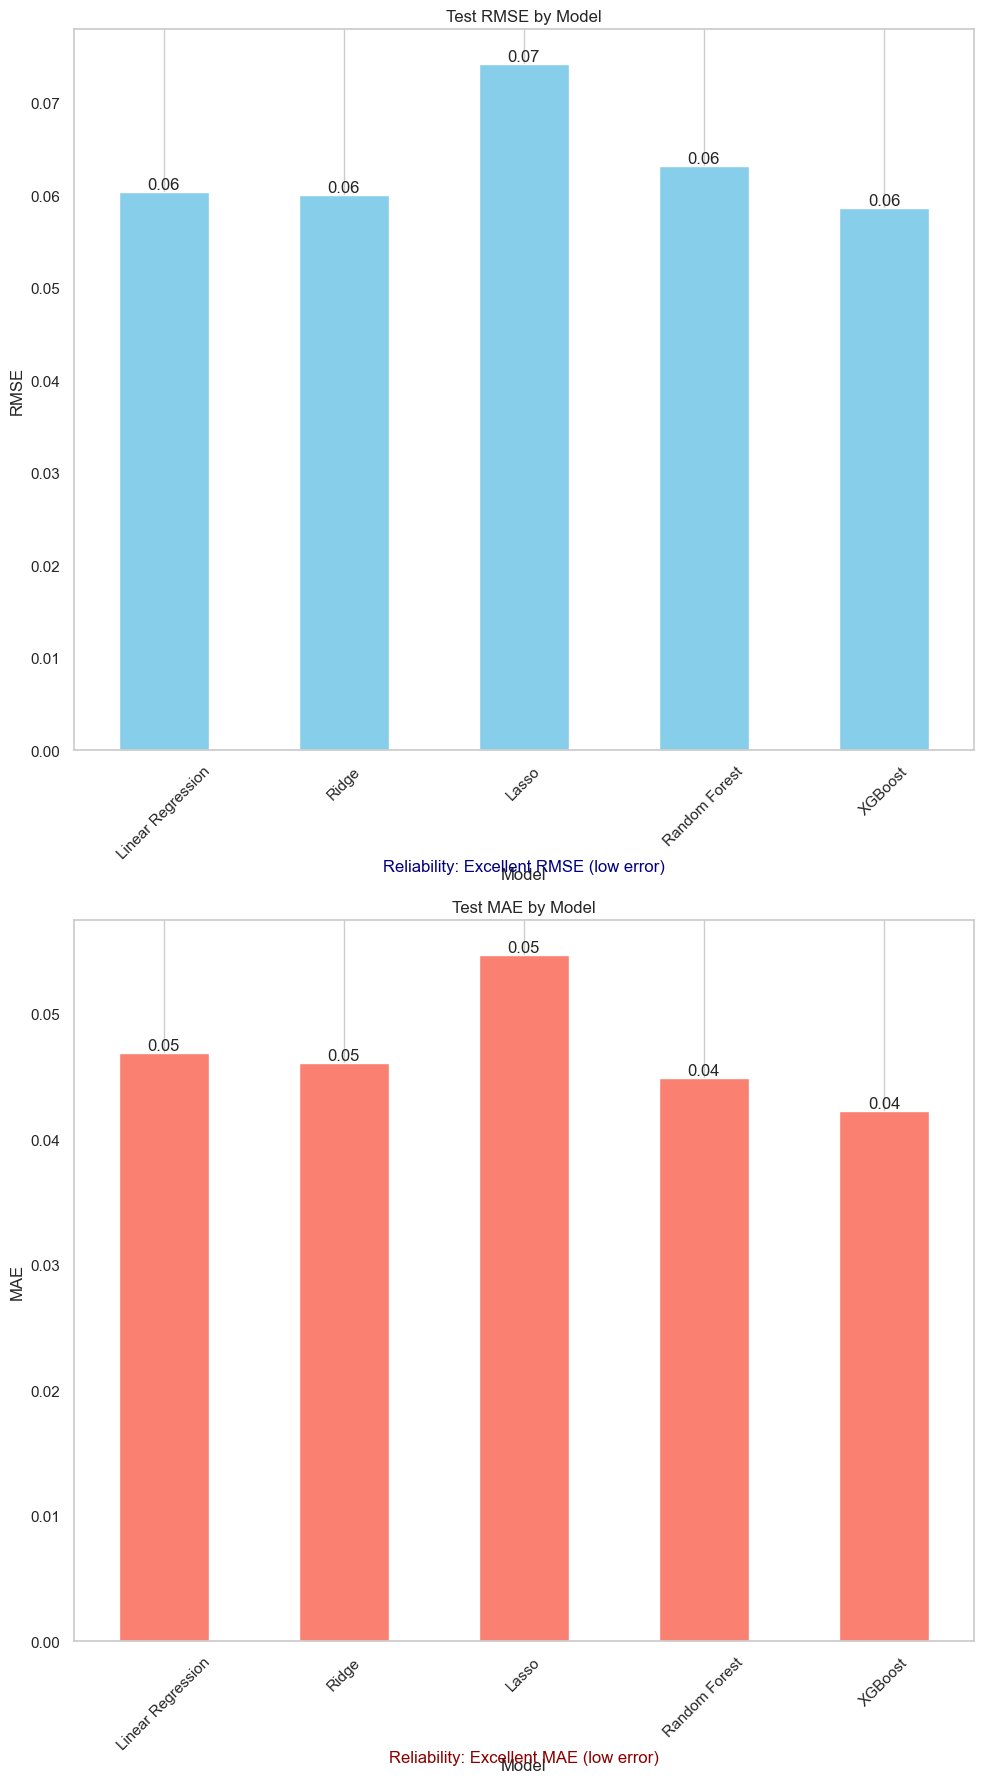

In [285]:
if 'Model' in results_df.columns:
    results_df = results_df.set_index('Model')

fig, axs = plt.subplots(2, 1, figsize=(10, 18))

# Plot RMSE
results_df['Test RMSE'].plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Test RMSE by Model')
axs[0].set_ylabel('RMSE')
axs[0].grid(axis='y')
axs[0].set_xticklabels(results_df.index, rotation=45)
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%.2f')

# RMSE reliability comment
mean_rmse = results_df['Test RMSE'].mean()
if mean_rmse < 5:
    comment_rmse = "Excellent RMSE (low error)"
elif mean_rmse < 10:
    comment_rmse = "Good RMSE"
elif mean_rmse < 15:
    comment_rmse = "Moderate RMSE"
else:
    comment_rmse = "Poor RMSE (high error)"
axs[0].text(0.5, -0.15, f'Reliability: {comment_rmse}', ha='center', va='top',
            transform=axs[0].transAxes, fontsize=12, color='navy')

# Plot MAE
results_df['Test MAE'].plot(kind='bar', ax=axs[1], color='salmon')
axs[1].set_title('Test MAE by Model')
axs[1].set_ylabel('MAE')
axs[1].grid(axis='y')
axs[1].set_xticklabels(results_df.index, rotation=45)
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%.2f')

# MAE reliability comment
mean_mae = results_df['Test MAE'].mean()
if mean_mae < 5:
    comment_mae = "Excellent MAE (low error)"
elif mean_mae < 10:
    comment_mae = "Good MAE"
elif mean_mae < 15:
    comment_mae = "Moderate MAE"
else:
    comment_mae = "Poor MAE (high error)"
axs[1].text(0.5, -0.15, f'Reliability: {comment_mae}', ha='center', va='top',
            transform=axs[1].transAxes, fontsize=12, color='darkred')

plt.tight_layout()
plt.show()

In [253]:
rf_params = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

In [254]:
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}
xgb_grid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42), xgb_params, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)
best_xgb = xgb_grid.best_estimator_

In [255]:
rf_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
selected_rf_features = rf_importances[rf_importances > 0.01].index.tolist()

xgb_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
selected_xgb_features = xgb_importances[xgb_importances > 0.01].index.tolist()

In [256]:
def time_series_cv_score(model, X, y, selected_features, scoring='neg_root_mean_squared_error'):
    tscv = TimeSeriesSplit(n_splits=5)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[selected_features])
    scores = -cross_val_score(model, X_scaled, y, cv=tscv, scoring=scoring)
    return scores.mean()

In [257]:
final_results = []

In [258]:
lr = LinearRegression()
lr_cv_rmse = time_series_cv_score(lr, X_train, y_train, selected_rf_features)
final_results.append({'Model': 'Linear Regression', 'CV RMSE': lr_cv_rmse})

In [259]:
ridge = Ridge(alpha=1.0)
ridge_cv_rmse = time_series_cv_score(ridge, X_train, y_train, selected_rf_features)
final_results.append({'Model': 'Ridge', 'CV RMSE': ridge_cv_rmse})

lasso = Lasso(alpha=0.01)
lasso_cv_rmse = time_series_cv_score(lasso, X_train, y_train, selected_rf_features)
final_results.append({'Model': 'Lasso', 'CV RMSE': lasso_cv_rmse})

best_rf_cv_rmse = time_series_cv_score(best_rf, X_train, y_train, selected_rf_features)
final_results.append({'Model': 'Random Forest (Tuned)', 'CV RMSE': best_rf_cv_rmse})

best_xgb_cv_rmse = time_series_cv_score(best_xgb, X_train, y_train, selected_xgb_features)
final_results.append({'Model': 'XGBoost (Tuned)', 'CV RMSE': best_xgb_cv_rmse})


In [260]:
final_results_df = pd.DataFrame(final_results)
print(final_results_df)

                   Model   CV RMSE
0      Linear Regression  0.080796
1                  Ridge  0.080906
2                  Lasso  0.082875
3  Random Forest (Tuned)  0.067091
4        XGBoost (Tuned)  0.057310


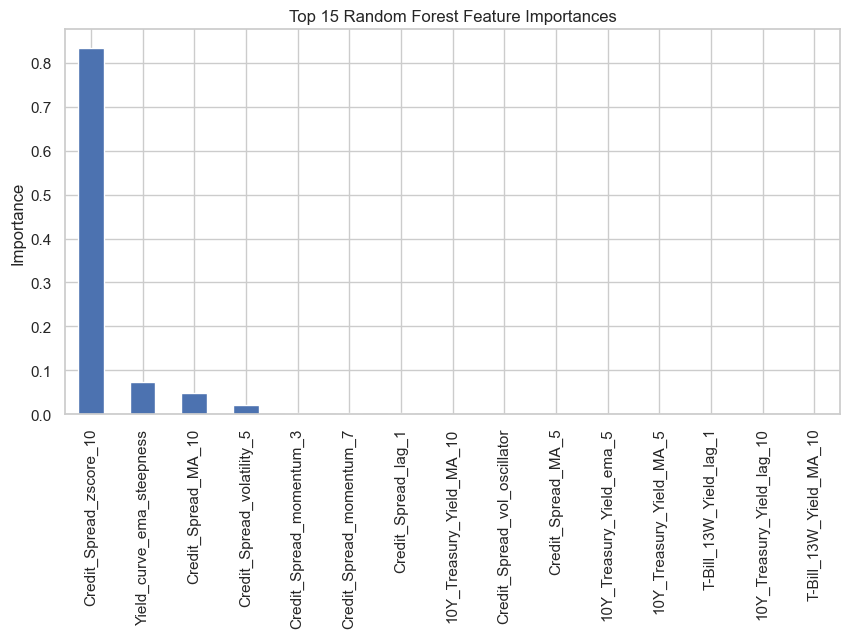

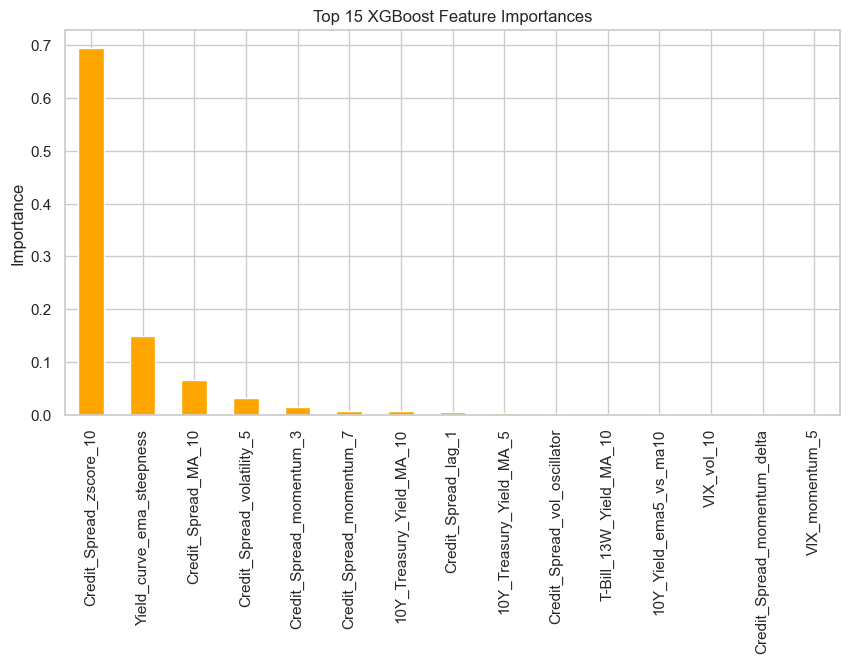

In [261]:
plt.figure(figsize=(10,5))
rf_importances.head(15).plot(kind='bar')
plt.title('Top 15 Random Forest Feature Importances')
plt.ylabel('Importance')
plt.show()

plt.figure(figsize=(10,5))
xgb_importances.head(15).plot(kind='bar', color='orange')
plt.title('Top 15 XGBoost Feature Importances')
plt.ylabel('Importance')
plt.show()

In [262]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.utils import resample
import warnings

In [263]:
warnings.filterwarnings("ignore")

In [264]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)


In [265]:
rf_params = {
    'n_estimators': [200, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

xgb_params = {
    'n_estimators': [200, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1]
}


In [266]:
def nested_cv(model, param_grid, X, y):
    outer_cv = TimeSeriesSplit(n_splits=5)
    inner_cv = TimeSeriesSplit(n_splits=3)
    
    grid = GridSearchCV(model, param_grid, cv=inner_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    scores = cross_val_score(grid, X, y, cv=outer_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    
    return -scores.mean(), scores.std()

In [267]:
rf_rmse, rf_std = nested_cv(rf, rf_params, X_train_scaled, y_train)
xgb_rmse, xgb_std = nested_cv(xgb, xgb_params, X_train_scaled, y_train)

print(f"Nested CV RMSE | Random Forest: {rf_rmse:.4f} ± {rf_std:.4f}")
print(f"Nested CV RMSE | XGBoost      : {xgb_rmse:.4f} ± {xgb_std:.4f}")

Nested CV RMSE | Random Forest: 0.0752 ± 0.0124
Nested CV RMSE | XGBoost      : 0.0554 ± 0.0126


In [268]:
rf_best = GridSearchCV(rf, rf_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_best = GridSearchCV(xgb, xgb_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)

rf_best.fit(X_train_scaled, y_train)
xgb_best.fit(X_train_scaled, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10], 'n_estimators': [200, 500],
                         'subsample': [0.7, 1]},
             scoring='neg_root_mean_squared_error')

In [269]:
ensemble = VotingRegressor([
    ('rf', rf_best.best_estimator_),
    ('xgb', xgb_best.best_estimator_)
])

ensemble.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=15,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=500,
                                          n_jobs=None, num_parallel_tree=None, ...))])

In [270]:
y_pred_ensemble = ensemble.predict(X_test_scaled)

In [271]:
pred_direction = np.sign(np.diff(y_pred_ensemble))
actual_direction = np.sign(np.diff(y_test))

direction_acc = np.mean(pred_direction == actual_direction)

print(f"\nEnsemble Test RMSE: {rmse:.4f}")
print(f"Ensemble Test MAE : {mae:.4f}")
print(f"Directional Accuracy: {direction_acc:.4f}")


Ensemble Test RMSE: 0.0586
Ensemble Test MAE : 0.0423
Directional Accuracy: 0.9807


In [276]:
def prediction_intervals(model, X, n_bootstrap=200, alpha=0.05, sample_size=500):
    preds = []
    
    for _ in range(n_bootstrap):
        X_sample, y_sample = resample(X_train_scaled, y_train, n_samples=min(1000, len(X_train_scaled)))
        model.fit(X_sample, y_sample)
        preds.append(model.predict(X))
        
    preds = np.array(preds)
    lower = np.percentile(preds, 100 * alpha / 2.0, axis=0)
    upper = np.percentile(preds, 100 * (1 - alpha / 2.0), axis=0)
    return lower, upper

lower_bound, upper_bound = prediction_intervals(rf_best.best_estimator_, X_test_scaled, n_bootstrap=50)

In [277]:
for i in range(5):
    print(f"Prediction: {y_pred_ensemble[i]:.2f}, CI: [{lower_bound[i]:.2f}, {upper_bound[i]:.2f}], Actual: {y_test[i]:.2f}")

Prediction: 1.28, CI: [1.22, 1.29], Actual: 1.27
Prediction: 1.67, CI: [1.60, 1.69], Actual: 1.64
Prediction: 1.92, CI: [1.89, 1.98], Actual: 1.96
Prediction: 0.69, CI: [0.70, 0.85], Actual: 0.58
Prediction: 1.41, CI: [1.36, 1.42], Actual: 1.42


In [282]:
y_test = y_test.reset_index(drop=True)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual Spread': y_test,
    'Predicted Spread': y_pred_ensemble
})

# Calculate percent change of Actual and Predicted
comparison_df['Difference'] = abs(comparison_df['Actual Spread'] - comparison_df['Predicted Spread'])

# Calculate percent prediction error
comparison_df['Error %'] = ((comparison_df['Predicted Spread'] - comparison_df['Actual Spread']) / comparison_df['Actual Spread']) * 100
comparison_df['Error %'] = comparison_df['Error %'].round(2)
# Optional: round values for clarity
comparison_df = comparison_df.round(4)

# Show the first few rows
print(comparison_df.head())

   Actual Spread  Predicted Spread  Difference  Error %
0         1.2659            1.2755      0.0096     0.76
1         1.6355            1.6721      0.0366     2.24
2         1.9584            1.9249      0.0335    -1.71
3         0.5799            0.6889      0.1090    18.79
4         1.4204            1.4069      0.0135    -0.95


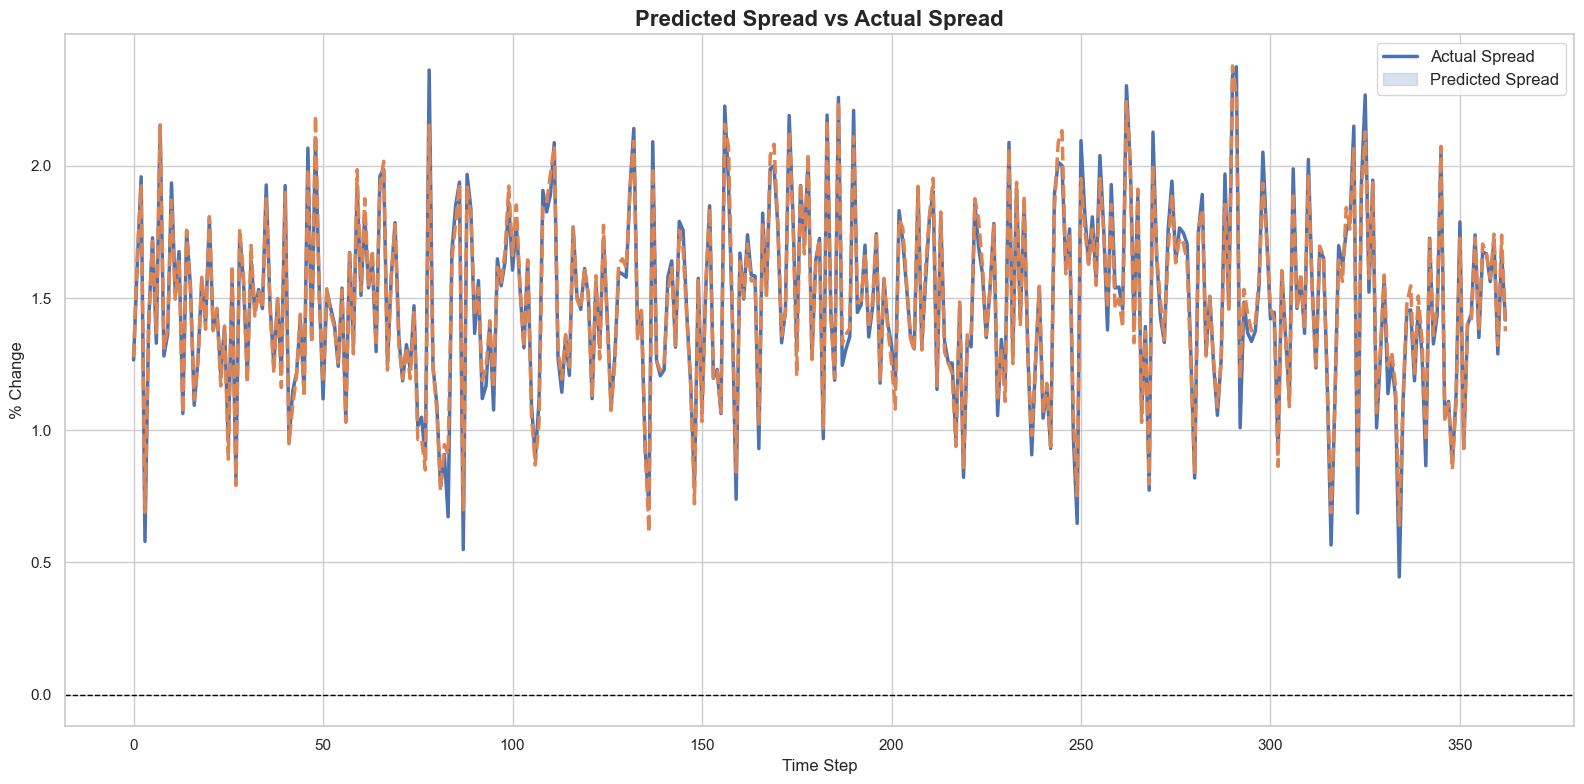

     Actual Spread  Predicted Spread  Difference  Error %
353         1.4400            1.4072      0.0328    -2.28
354         1.7389            1.7265      0.0124    -0.71
355         1.3506            1.3844      0.0337     2.50
356         1.6738            1.7044      0.0305     1.82
357         1.6672            1.6676      0.0004     0.02
358         1.5620            1.5750      0.0130     0.83
359         1.7203            1.7416      0.0213     1.24
360         1.2890            1.3216      0.0326     2.53
361         1.6721            1.7378      0.0657     3.93
362         1.4170            1.3748      0.0422    -2.98


In [283]:
# Plot Actual vs Predicted values
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")

sns.lineplot(data=comparison_df[['Actual Spread', 'Predicted Spread']], linewidth=2.5)
plt.title('Predicted Spread vs Actual Spread', fontsize=16, weight='bold')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('% Change', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(['Actual Spread', 'Predicted Spread'], fontsize=12)
plt.tight_layout()
plt.show()

# Display top rows
print(comparison_df.tail(10))

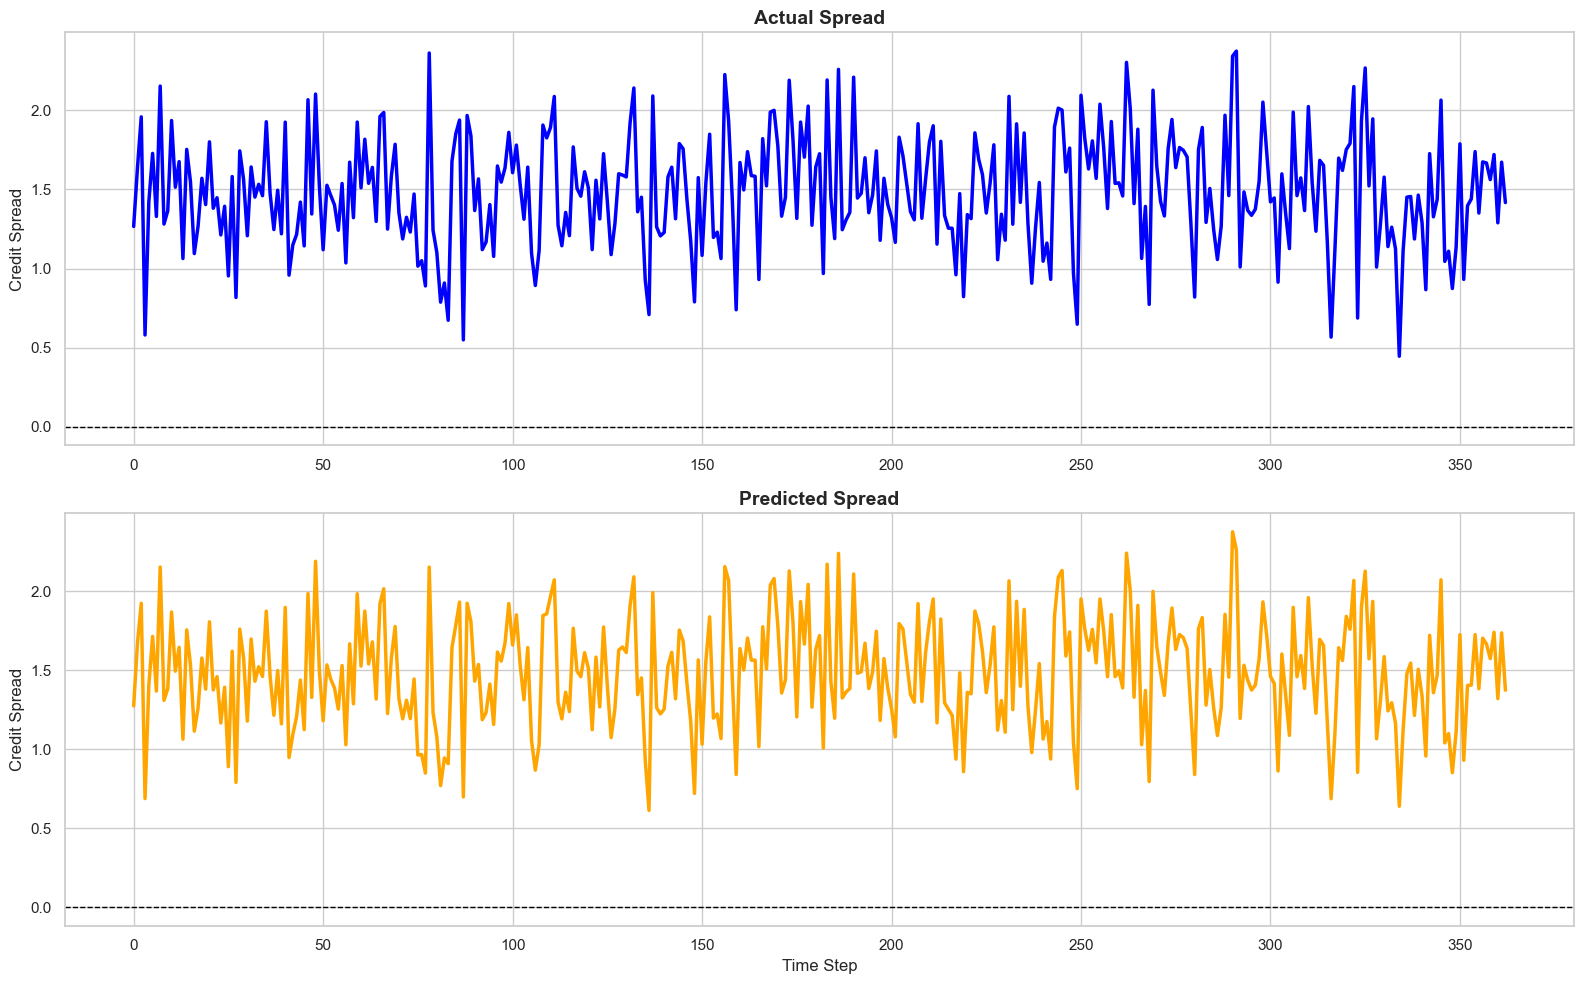

In [284]:
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Subplot 1: Actual values
plt.subplot(2, 1, 1)
sns.lineplot(data=comparison_df['Actual Spread'], color='blue', linewidth=2.5)
plt.title('Actual Spread', fontsize=14, weight='bold')
plt.ylabel('Credit Spread')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Subplot 2: Predicted values
plt.subplot(2, 1, 2)
sns.lineplot(data=comparison_df['Predicted Spread'], color='orange', linewidth=2.5)
plt.title('Predicted Spread', fontsize=14, weight='bold')
plt.xlabel('Time Step')
plt.ylabel('Credit Spread')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

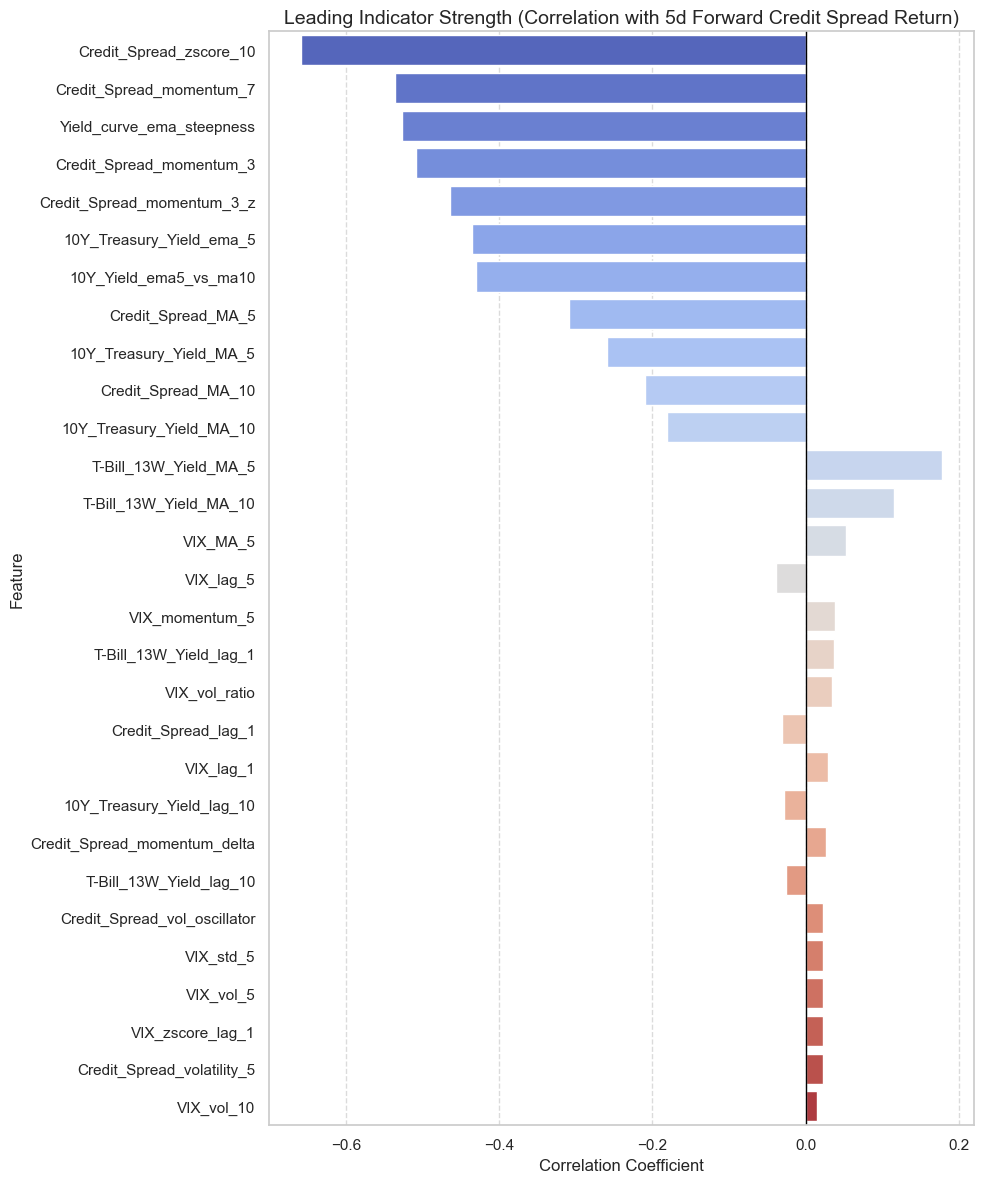

In [289]:
df_main['Credit_Spread_return_5'] = df_main['Credit_Spread'].shift(-5) - df_main['Credit_Spread']

exclude_cols = ['10Y_Treasury_Yield', 'T-Bill_13W_Yield', 'Credit_Spread',
    'Yield_Curve_Steepness', '10Y_Treasury_Yield_to_MA_5_diff', '10Y_Treasury_Yield_to_MA_10_diff',
    'T-Bill_13W_Yield_to_MA_5_diff', 'T-Bill_13W_Yield_to_MA_10_diff',
    'Credit_Spread_to_MA_5_diff', 'Credit_Spread_to_MA_10_diff',
    'VIX_x_Yield_Steepness', 'VIX_pct_x_Yield_Steepness',
    'Credit_Spread_return_5', 'Credit_Spread_pct_change',
    "Credit_Spread_vol_of_vol_5", "10Y_Treasury_Yield_lag_5", "VIX_pct_change",
    "Credit_Spread_lag_10", "Credit_Spread_lag_5", "VIX_zscore",
    "High_vol_regime", "Credit_Spread_volatility_10", "VIX_to_MA_10_diff",
    "T-Bill_13W_Yield_lag_5", "High_VIX_flag", "Spread_reversal_flag",
    "VIX_lag_10", "VIX_to_MA_5_diff", "VIX", "VIX_MA_10",
    "10Y_Treasury_Yield_lag_1", 'Regime', 'T-Bill_13W_Yield',]  
numeric_features = [col for col in df_main.select_dtypes(include=np.number).columns if col not in exclude_cols]

lead_scores = {}
for feature in numeric_features:
    corr = df_main[feature].corr(df_main['Credit_Spread_return_5'])
    lead_scores[feature] = corr

lead_scores_df = pd.DataFrame.from_dict(lead_scores, orient='index', columns=['Correlation_with_5d_Return'])
lead_scores_df['abs_corr'] = lead_scores_df['Correlation_with_5d_Return'].abs()
lead_scores_df.sort_values(by='abs_corr', ascending=False, inplace=True)

plt.figure(figsize=(10, 12))
sns.barplot(x='Correlation_with_5d_Return', y=lead_scores_df.index, data=lead_scores_df, palette='coolwarm')
plt.title('Leading Indicator Strength (Correlation with 5d Forward Credit Spread Return)', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

In [290]:
display_cols = ['Correlation_with_5d_Return']
print("Top Leading Indicators (Correlation with 5d Forward Credit Spread Return):\n")
print(lead_scores_df[display_cols].round(4).to_string())

Top Leading Indicators (Correlation with 5d Forward Credit Spread Return):

                              Correlation_with_5d_Return
Credit_Spread_zscore_10                          -0.6586
Credit_Spread_momentum_7                         -0.5359
Yield_curve_ema_steepness                        -0.5264
Credit_Spread_momentum_3                         -0.5087
Credit_Spread_momentum_3_z                       -0.4640
10Y_Treasury_Yield_ema_5                         -0.4351
10Y_Yield_ema5_vs_ma10                           -0.4306
Credit_Spread_MA_5                               -0.3086
10Y_Treasury_Yield_MA_5                          -0.2588
Credit_Spread_MA_10                              -0.2097
10Y_Treasury_Yield_MA_10                         -0.1806
T-Bill_13W_Yield_MA_5                             0.1777
T-Bill_13W_Yield_MA_10                            0.1146
VIX_MA_5                                          0.0532
VIX_lag_5                                        -0.0389
VIX_momentum

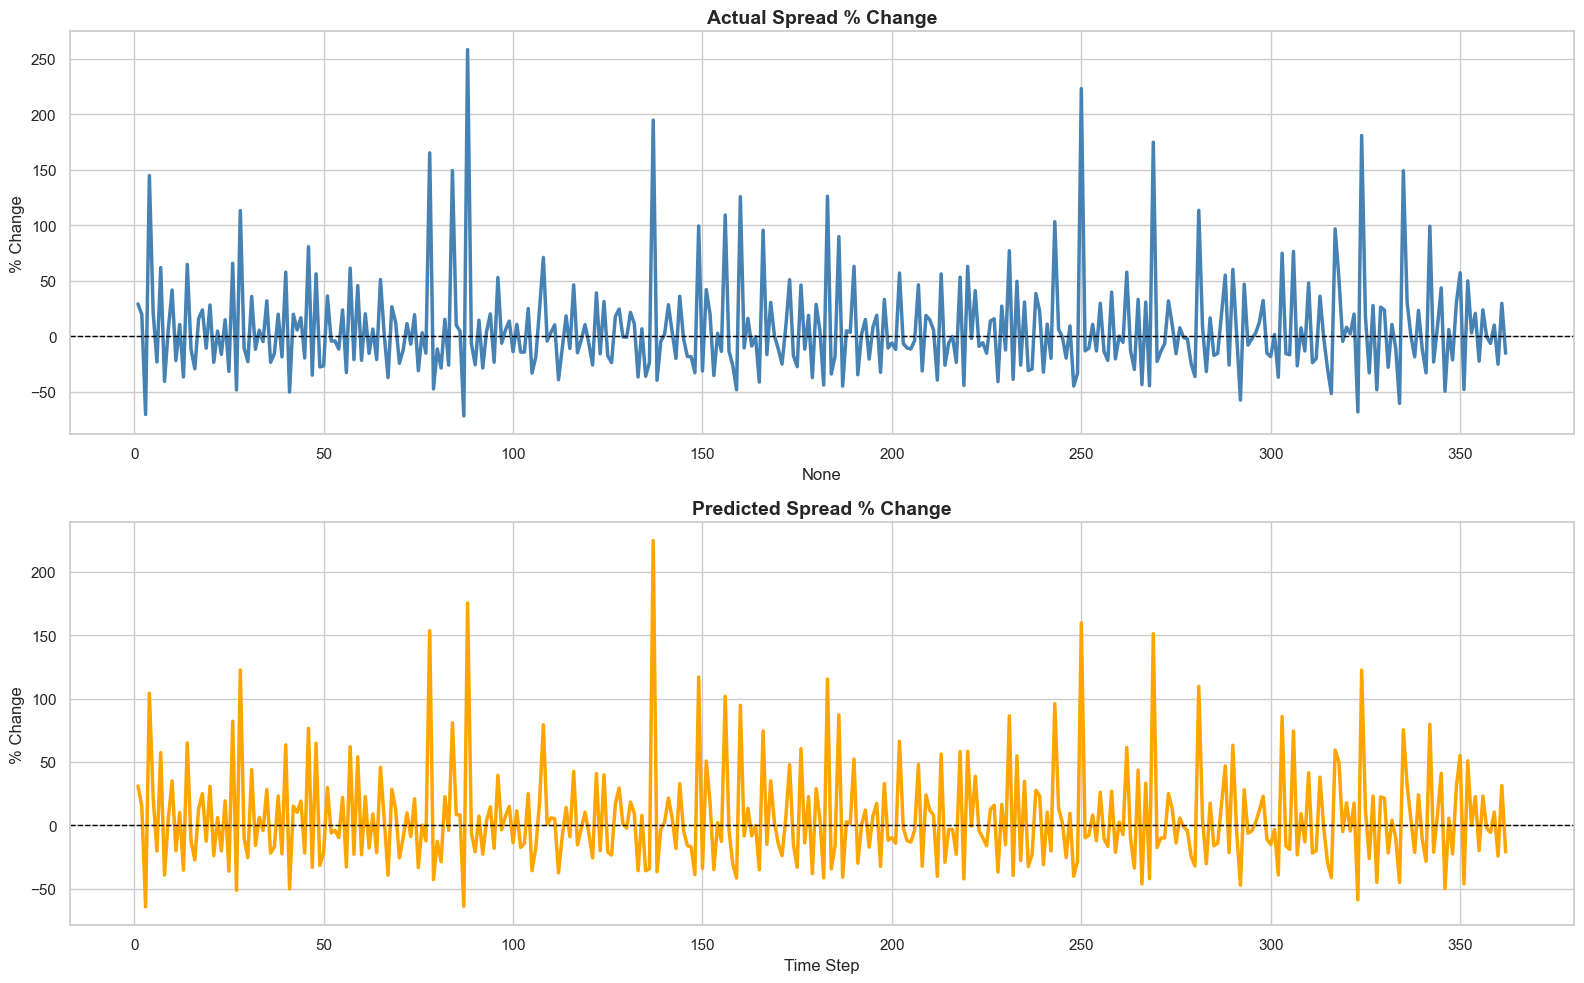

In [303]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 10))

# Calculate percentage changes
comparison_df['Actual_Pct_Change'] = comparison_df['Actual Spread'].pct_change() * 100
comparison_df['Predicted_Pct_Change'] = comparison_df['Predicted Spread'].pct_change() * 100

# Subplot 1: Actual % Change as a line plot
plt.subplot(2, 1, 1)
sns.lineplot(x=comparison_df.index, y='Actual_Pct_Change', data=comparison_df, color='steelblue', linewidth=2.5)
plt.title('Actual Spread % Change', fontsize=14, weight='bold')
plt.ylabel('% Change')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Subplot 2: Predicted % Change as a line plot
plt.subplot(2, 1, 2)
sns.lineplot(x=comparison_df.index, y='Predicted_Pct_Change', data=comparison_df, color='orange', linewidth=2.5)
plt.title('Predicted Spread % Change', fontsize=14, weight='bold')
plt.xlabel('Time Step')
plt.ylabel('% Change')
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


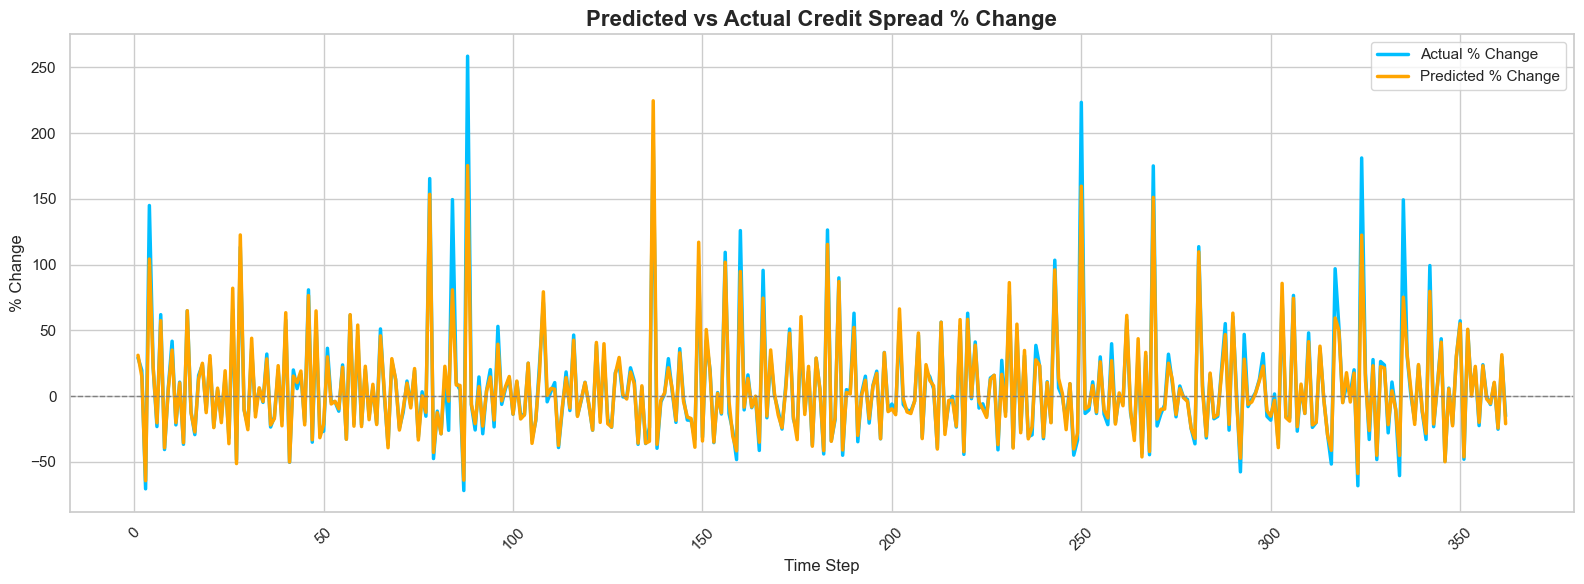

In [302]:
comparison_df['Actual_Pct_Change'] = comparison_df['Actual Spread'].pct_change() * 100
comparison_df['Predicted_Pct_Change'] = comparison_df['Predicted Spread'].pct_change() * 100

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

# Plot lines
sns.lineplot(
    data=comparison_df['Actual_Pct_Change'],
    label='Actual % Change',
    color='deepskyblue',
    linewidth=2.5
)

sns.lineplot(
    data=comparison_df['Predicted_Pct_Change'],
    label='Predicted % Change',
    color='orange',
    linewidth=2.5
)

# Axis and labels
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Predicted vs Actual Credit Spread % Change', fontsize=16, weight='bold')
plt.xlabel('Time Step')
plt.ylabel('% Change')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [304]:
X

,VIX_lag_1,VIX_lag_5,T-Bill_13W_Yield_lag_1,T-Bill_13W_Yield_lag_10,10Y_Treasury_Yield_lag_10,Credit_Spread_lag_1,VIX_MA_5,T-Bill_13W_Yield_MA_5,T-Bill_13W_Yield_MA_10,10Y_Treasury_Yield_MA_5,Credit_Spread_zscore_10,VIX_momentum_5,10Y_Treasury_Yield_ema_5,Credit_Spread_volatility_5,Credit_Spread_momentum_delta,10Y_Yield_ema5_vs_ma10,Credit_Spread_momentum_3_z,Yield_curve_ema_steepness,Credit_Spread_vol_oscillator,VIX_zscore_lag_1
2020-01-01,0.374540,0.642032,0.103124,0.168935,0.707239,0.185133,0.758263,0.167042,0.191867,0.956501,0.261706,0.976800,0.340604,0.629558,0.792595,0.672703,0.553371,0.067256,0.141224,0.296358
2020-01-02,0.950714,0.084140,0.902553,0.278590,0.152539,0.541901,0.024587,0.167619,0.323372,0.737508,0.246979,0.110721,0.071712,0.054332,0.907899,0.796681,0.503132,0.094918,0.570877,0.938316
2020-01-03,0.731994,0.161629,0.505252,0.177010,0.576288,0.872946,0.022124,0.036671,0.226656,0.353251,0.906255,0.422548,0.409629,0.748645,0.943702,0.250468,0.193863,0.998893,0.185270,0.818740
2020-01-06,0.598658,0.898554,0.826457,0.088703,0.606715,0.732225,0.323610,0.736402,0.354996,0.296536,0.249546,0.042025,0.311217,0.317587,0.960136,0.624874,0.858817,0.326639,0.278643,0.983567
2020-01-07,0.156019,0.606429,0.320050,0.120636,0.424131,0.806561,0.488643,0.663805,0.069424,0.349703,0.271950,0.739904,0.677121,0.000135,0.521460,0.571746,0.676941,0.748184,0.218710,0.259671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30,0.349210,0.930757,0.473962,0.872124,0.091582,0.871537,0.828883,0.578387,0.084792,0.656955,0.447056,0.345877,0.775346,0.593561,0.865296,0.505634,0.996158,0.644745,0.658718,0.442107
2020-10-01,0.725956,0.858413,0.667558,0.932118,0.917314,0.973489,0.430888,0.274161,0.716323,0.956615,0.460358,0.154460,0.271409,0.073082,0.157273,0.941121,0.825416,0.229827,0.532292,0.334401
2020-10-02,0.897110,0.428994,0.172320,0.565133,0.136819,0.968878,0.248714,0.079419,0.072084,0.068958,0.864564,0.025448,0.496695,0.622343,0.309788,0.876319,0.844871,0.552662,0.103265,0.394572
2020-10-05,0.887086,0.750871,0.192289,0.696651,0.950237,0.749652,0.617145,0.085658,0.071257,0.057055,0.546648,0.645822,0.284274,0.981178,0.290046,0.102568,0.249009,0.372173,0.172524,0.529941
